# Introduction to Networkx

`Networkx` (typically imported as `nx`) is one of the most common Python packages for working with network data. You can find the [documentation here](https://networkx.org/documentation/stable/index.html). To get us started here are some networkx basics:

In [2]:
# import the networkx package
import networkx as nx

In [3]:
# create an empty, undirected network 
G = nx.Graph()

In [4]:
# add a node
G.add_node('a')
print(G.nodes())

['a']


In [5]:
# add an edge, this will automatically add missing nodes
G.add_edge('b', 'c')
print(G.nodes())
print(G.edges())

['a', 'b', 'c']
[('b', 'c')]


In [6]:
# add an edge with weight
G.add_edge('a', 'c', weight=1)

# to access edge (or node) attributes, you need to set data=True. Eg:
print('Just the node-node pairs:')
print(G.edges())

print('\nSetting data=True to get edge attributes')
print(G.edges(data=True))

Just the node-node pairs:
[('a', 'c'), ('b', 'c')]

Setting data=True to get edge attributes
[('a', 'c', {'weight': 1}), ('b', 'c', {})]


For edges where the weight is specified, we can access that using using the nodes and attribute name as keys. In an undirected network, it doesn't matter which order you put the node-keys in:

In [7]:
print(G['a']['c']['weight'])
print(G['c']['a']['weight'])

1
1


Note that we didn't specify a weight when we added the edge `b - c`. By default, no attributes are specified, so we can't access the "weight" of this edge without adding "weight" as an attribute first. Eg, the following code will throw an error:

In [7]:
print(G['b']['c']['weight'])

KeyError: 'weight'

But, can use the dictionary method `.setdefault()` to ensure the attribute is added if we need to. More on dictionaries soon!

In [8]:
# increment weights
for i, j in G.edges():  # for every edge
    G[i][j].setdefault('weight', 0) # set the default weight to zero
    G[i][j]['weight'] += 1 # NOW every edge has a weight so we can do things with it
    
print(G.edges(data=True)) # print with weights

[('a', 'c', {'weight': 2}), ('b', 'c', {'weight': 1})]


Note: You can add arbitrary node or edge attributes. There is no set list of attribute names you have to draw from. Attributes can be a range of types.

In [9]:
# add attributes to existing nodes
nx.set_node_attributes(G, values={'a': [1, 2, 3]}, name='records')
nx.set_node_attributes(G, values={'b': 1}, name='count')
nx.set_node_attributes(G, values={'c': 'sunny'}, name='weather')

print(G.nodes(data=True))

[('a', {'records': [1, 2, 3]}), ('b', {'count': 1}), ('c', {'weather': 'sunny'})]


# Text and Networks
# Example 1: Hashtag co-occurance

Nodes are the hashtags which appear in a given set of tweets. Edges represent if two hashtags co-occur in the same tweet. Weight of edge indicates number of times they co-occur.

In [10]:
# packages we will need for this example
import json # loading data
import networkx as nx # for networks!
import numpy as np # for math
import itertools as it # fancy iteration
import matplotlib.pyplot as plt # visualizations

In [11]:
filename = 'tweets.json'

with open(filename, 'r') as fp:
    tweets = json.loads(fp.read())
    
print('{} tweets loaded'.format(len(tweets)))

59967 tweets loaded


## Data format and background
These tweets were collected from the Twitter API using a list of "Black Lives Matter" related keywords. All tweets were made between in April and May of 2021. The dataset has already been trimmed to only include tweets with at least one hashtag. All collected tweets were public on Twitter at the time of data collection. Content warning: no additional filtering has been done and the dataset may include vile and offensive language.

**Data Format** The Twitter API returns objects in JSON format. Here, using `json.loads()` reads the data into the object `tweets`, which is a list of **dictionary** objects. This data format has a key, value format -- eg, keys are used to "look up" values in the dictionary. In other words, if we were to print out `tweets` it would be a list that would look something like this:
```
tweets = [{tweet 1 dictionary},
          {tweet 2 dictionary},
          ...
          {tweet n dictionary}
          ]
```

Since `tweets` is a list, we can find out how many tweets it contains using `len()` (eg, equivalent of "length" for R users). We can access a specific tweet using it's index (Note: the first element is at index 0). or by iterating over the list (eg: `for tweet in tweets:`).

Let's look at the first tweet in the dataset:

In [12]:
tweets[0]

{'text': '@MrAndyNgo But #BLM is all about peace according to @VP.',
 'entities': {'hashtags': [{'start': 15, 'end': 19, 'tag': 'BLM'}],
  'mentions': [{'start': 0, 'end': 10, 'username': 'MrAndyNgo'},
   {'start': 52, 'end': 55, 'username': 'VP'}]},
 'context_annotations': [{'domain': {'id': '10',
    'name': 'Person',
    'description': 'Named people in the world like Nelson Mandela'},
   'entity': {'id': '875006493984149509',
    'name': 'Kamala Harris',
    'description': 'US Senator Kamala Harris (CA)'}},
  {'domain': {'id': '10',
    'name': 'Person',
    'description': 'Named people in the world like Nelson Mandela'},
   'entity': {'id': '1161294453560098822', 'name': 'Andy Ngo'}},
  {'domain': {'id': '35',
    'name': 'Politician',
    'description': 'Politicians in the world, like Joe Biden'},
   'entity': {'id': '875006493984149509',
    'name': 'Kamala Harris',
    'description': 'US Senator Kamala Harris (CA)'}}],
 'public_metrics': {'retweet_count': 1,
  'reply_count': 0,


Here, we see that each tweet dictionary contains a lot of information about the tweet, which is all contained in nested dictionary objects. We can use `[key]` to access a given key-value pair (where the value may be a dictionary!) and we can use `.keys()` to see all available keys. Eg, the top-level keys available for this tweet are:

In [57]:
tweet = tweets[0] # save this as tweet of interest
tweet.keys()

dict_keys(['text', 'entities', 'context_annotations', 'public_metrics', 'author_id', 'id', 'in_reply_to_user_id', 'created_at', 'lang', 'referenced_tweets', 'conversation_id'])

While we could work directly with the `text` Twitter makes hashtag analysis particularly easy by indentifying the specific hashtags which exist in the tweet. Note that field *only* stores items which were explicitly denoted as hashtags (using '#'). Eg, given the text:

```
The hashtag for BLM is #BLM
```
Only the second reference of BLM will count as a hashtag. Something to think about if you're working with Twitter data: **which string do you want to be considered as nodes?**

Hashtags included in a tweets are stored under entities -> hashtags. Hashtags will be stored in a list with a record of the tag itself and where it appears in the tweet. Eg:

In [14]:
tweet['entities']['hashtags']

[{'start': 15, 'end': 19, 'tag': 'BLM'}]

In [15]:
# start : 15 and end : 19 are tell you exactly where the hashtag can be found in the tweet:
tweet['text'][15:19]

'#BLM'

In [58]:
# can extract just the 'tag' information using a list comprehension:
#tag_details = tweet['entities']['hashtags']  

# only key the 'tag' part of each hashtag
hashtags = [details['tag'] for details in tweet['entities']['hashtags'] ]

print(hashtags)

['BLM']


We can also retrieve hashtags "the old fashioned way" by iterating over word in the tweet and looking for words that start with the '#' symbol. 

Note that in Python `split()` can be used to split a string into a list, similar to the R function strsplit(tweet, " "). By default, `split()` will split on spaces, but you can pass any character/collection of characters, eg `split(',')` or `split(' and ')`.

In [60]:
tweet['text'].split()

['@MrAndyNgo',
 'But',
 '#BLM',
 'is',
 'all',
 'about',
 'peace',
 'according',
 'to',
 '@VP.']

In [17]:
# just show spliting the string and iterating over each word
for word in tweet['text'].split():
    print(word)

@MrAndyNgo
But
#BLM
is
all
about
peace
according
to
@VP.


In [18]:
# get hashtags

hashtags = list() # empty list to store hashtags

for word in tweet['text'].split(): # iterate over each word
    if word[0] == '#': # if the 0-index element is #
        hashtags.append(word) # keep it as a hashtag
        
print(hashtags)

['#BLM']


## Making a network
To turn this into a hashtag co-occurance network we need to iterate through every tweet, saving every hashtag as a node and saving an edge between every pair of hashtags. If we see a hashtag pair more than once, we'll increase the weight of that edge.

We'll store our network data using `Networkx` (which we've imported as `nx`). You can find the [documentation here](https://networkx.org/documentation/stable/index.html).

In [62]:
a = [1, 2, 3, 4]

for i, j in it.permutations(a, 2):
    print(i, j)

1 2
1 3
1 4
2 1
2 3
2 4
3 1
3 2
3 4
4 1
4 2
4 3


In [70]:
tweet['entities']['hashtags']

[{'start': 35, 'end': 43, 'tag': 'America'},
 {'start': 47, 'end': 61, 'tag': 'StopAsianHate'},
 {'start': 97, 'end': 107, 'tag': 'idiocracy'},
 {'start': 109, 'end': 126, 'tag': 'BlackLivesMatter'},
 {'start': 128, 'end': 146, 'tag': 'NoHopeforHumanity'},
 {'start': 147, 'end': 156, 'tag': 'EpicFail'}]

In [63]:
G = nx.Graph() # init empty network

for tweet in tweets: # iterate over all tweets
    
    # note: all tweets in this dataset have hashtags
    tag_details = tweet['entities']['hashtags']  
    
    # only key the 'tag' part of each hashtag
    hashtags = [details['tag'] for details in tag_details]
    
    # if there's only 1 hashtag, we have a node but no edge
    if len(hashtags) == 1:
        h1 = hashtags[0]
        G.add_node(h1) # add node (won't replace)
        G.nodes[h1].setdefault('count', 0)
        G.nodes[h1]['count'] += 1
        
    else:
        for h1, h2 in it.combinations(hashtags, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
            
            G.nodes[h1].setdefault('count', 0)
            G.nodes[h1]['count'] += 1
            
            G.nodes[h2].setdefault('count', 0)
            G.nodes[h2]['count'] += 1
            
print('{} nodes (hashtags) found'.format(len(G)))

34649 nodes (hashtags) found


### Simple Network Analysis

In [20]:
# we can retrieve the weighted degree distribution using:
degrees = dict(G.degree(weight='weight'))

# this will return a dictionary where the keys are hashtags and the values are the degree
# {'BlackLivesMatter': 68290, 'BLM': 47576}

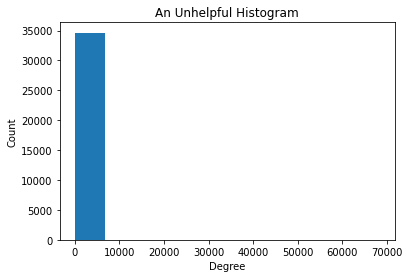

In [21]:
# Many networks have a heavy tailed degree distribution, which makes typical histograms not very helpful

plt.hist(degrees.values())
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('An Unhelpful Histogram')
plt.show()

In [76]:
data = degrees.values()
lower_bound = min(data) + 1
upper_bound = max(data) + 1

print(lower_bound, upper_bound)

1 81480


In [79]:
nb= 50
lower_bound = np.log10(lower_bound) if lower_bound > 0 else 0
upper_bound = np.log10(upper_bound)

bins = np.logspace(lower_bound, upper_bound, nb)

In [80]:
bins

array([1.00000000e+00, 1.25957935e+00, 1.58654013e+00, 1.99837318e+00,
       2.51710959e+00, 3.17049925e+00, 3.99349538e+00, 5.03012430e+00,
       6.33584068e+00, 7.98049407e+00, 1.00520655e+01, 1.26613741e+01,
       1.59480053e+01, 2.00877781e+01, 2.53021505e+01, 3.18700662e+01,
       4.01428772e+01, 5.05631390e+01, 6.36882856e+01, 8.02204492e+01,
       1.01044021e+02, 1.27272962e+02, 1.60310394e+02, 2.01923662e+02,
       2.54338874e+02, 3.20359993e+02, 4.03518831e+02, 5.08263986e+02,
       6.40198819e+02, 8.06381211e+02, 1.01570112e+03, 1.27935615e+03,
       1.61145059e+03, 2.02974988e+03, 2.55663103e+03, 3.22027964e+03,
       4.05619772e+03, 5.10910288e+03, 6.43532047e+03, 8.10579676e+03,
       1.02098942e+04, 1.28601719e+04, 1.61984069e+04, 2.04031787e+04,
       2.56994226e+04, 3.23704619e+04, 4.07731652e+04, 5.13570369e+04,
       6.46882629e+04, 8.14800000e+04])

In [82]:
a

[1, 2, 3, 4]

In [83]:
a[1:]

[2, 3, 4]

In [ ]:
x = bins[1:] - np.diff(bins) / 2.0 

In [81]:
np.diff(bins)

array([2.59579347e-01, 3.26960784e-01, 4.11833051e-01, 5.18736406e-01,
       6.53389664e-01, 8.22996126e-01, 1.03662892e+00, 1.30571638e+00,
       1.64465339e+00, 2.07157144e+00, 2.60930860e+00, 3.28663122e+00,
       4.13977281e+00, 5.21437234e+00, 6.56791570e+00, 8.27281097e+00,
       1.04202618e+01, 1.31251466e+01, 1.65321636e+01, 2.08235718e+01,
       2.62289410e+01, 3.30374324e+01, 4.16132675e+01, 5.24152123e+01,
       6.60211189e+01, 8.31588378e+01, 1.04745155e+02, 1.31934834e+02,
       1.66182391e+02, 2.09319908e+02, 2.63655033e+02, 3.32094435e+02,
       4.18299291e+02, 5.26881148e+02, 6.63648612e+02, 8.35918086e+02,
       1.05290516e+03, 1.32621759e+03, 1.67047629e+03, 2.10409743e+03,
       2.65027767e+03, 3.33823501e+03, 4.20477188e+03, 5.29624382e+03,
       6.67103933e+03, 8.40270336e+03, 1.05838716e+04, 1.33312261e+04,
       1.67917371e+04])

In [22]:
# instead, will bin our data and look at it on log-log plot

# first, a function for binning our data

def binning(data,nb=50,log=True):
    # Seperate a vector of data into linear or log bins

    # Input:
    #   data : a vector of data
    #   bins : the number of bins to output (default: 50) 
    #   log : whether to log bin the data (default: True)

    # Output:
    #   x : the the midpoint of each bin
    #   y: the height of each bin 

    # coerce data to list
    data = list(data)
    
    # 1. find the data's upper and lower bounds
    lower_bound = min(data)
    upper_bound = max(data) + 1

    # 2. Define bins
    if log:
        lower_bound = np.log10(lower_bound) if lower_bound > 0 else 0
        upper_bound = np.log10(upper_bound)
        bins = np.logspace(lower_bound, upper_bound, nb)

    else:
        bins = np.linspace(lower_bound, upper_bound, nb)
    
    # 3. Compute the midpoint of each bin
    x = bins[1:] - np.diff(bins) / 2.0 

    # 4. Compute the height of each bin
    y, __ = np.histogram(data, 
                         weights=np.ones(len(data))/len(data),
                         bins = bins, 
                         density=False)

    return x, y

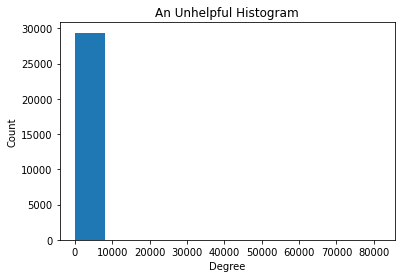

In [71]:
plt.hist(degrees.values())
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('An Unhelpful Histogram')
plt.show()

In [72]:
degrees.values()

dict_values([61951, 2650, 6537, 971, 81479, 780, 741, 734, 929, 9, 1124, 9, 9, 5, 3020, 2, 1362, 4679, 49, 44, 31, 38, 23, 2644, 23, 23, 33, 4877, 178, 25, 4237, 6, 33, 5, 46, 4, 15, 15, 15, 15, 15, 138, 36, 585, 3, 3, 3, 3, 228, 4196, 425, 2800, 364, 11475, 2179, 1420, 218, 24, 83, 109, 90, 63, 2, 315, 1796, 431, 668, 3404, 320, 315, 315, 315, 411, 443, 549, 356, 1960, 2, 92, 1943, 4, 3123, 621, 79, 1135, 716, 170, 1307, 26, 213, 1235, 3063, 1390, 469, 9, 43, 3655, 240, 89, 9, 630, 5, 383, 899, 5, 23, 20, 58, 1034, 3067, 11, 178, 616, 414, 18, 909, 1232, 22, 90, 108, 3523, 3457, 92, 48, 825, 2582, 67, 145, 1667, 2, 1839, 2, 1837, 22, 62, 229, 1962, 376, 228, 182, 0, 388, 0, 175, 41, 235, 131, 328, 165, 337, 1440, 9, 10, 38, 10, 9, 46, 3, 501, 4, 571, 29, 1016, 184, 5, 5, 215, 5, 3, 4514, 3, 1, 706, 13, 5, 150, 3207, 3382, 3289, 3177, 5164, 3783, 7836, 3275, 3874, 3293, 222, 4, 4, 19, 7, 122, 351, 4, 62, 71, 3, 38, 65, 17, 214, 186, 74, 17, 689, 106, 3150, 410, 188, 0, 503, 99, 225, 17

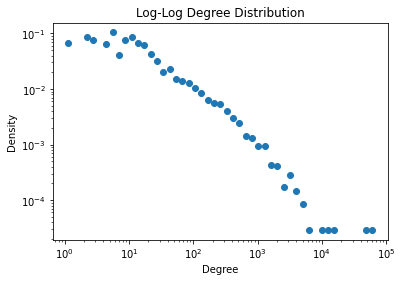

In [23]:
x, y = binning(degrees.values())

plt.loglog(x, y, marker='o', linewidth=0)
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Log-Log Degree Distribution')
plt.show()

### Look at top hashtags

In [86]:
for i, item in enumerate(a):
    print(i, item)

0 1
1 2
2 3
3 4


In [24]:
# the items in the degrees dictionary will be stored in arbitrary order

for i, (node, degree) in enumerate(degrees.items()):
    if i < 5:
        print(node, degree)

BLM 47576
art 2564
artists 763
BlackLivesMatter 68290
CrisisArt 734


In [25]:
# we can sort this form highest to lowest using:
sorted_degrees = dict(sorted(dict(degrees).items(), key=lambda item: item[1], reverse=True))

for i, (node, degree) in enumerate(sorted_degrees.items()):
    if i < 10:
        print(node, degree)

BlackLivesMatter 68290
BLM 47576
blm 15951
blacklivesmatter 13136
GeorgeFloyd 10069
LGBTQ 6560
racism 4793
Resist 4579
DaunteWright 4542
FBR 4216


### Removing capitalization
What if we want "BLM" and "blm" to be the same node? We could adjust for this in our current network, but it's actually easier to just rebuild the network and force everything to be lower case

In [88]:
for item in hashtags:
    print(item, item.lower())

America america
StopAsianHate stopasianhate
idiocracy idiocracy
BlackLivesMatter blacklivesmatter
NoHopeforHumanity nohopeforhumanity
EpicFail epicfail


In [26]:
G = nx.Graph() # init empty network

for tweet in tweets: # iterate over all tweets
    
    # note: all tweets in this dataset have hashtags
    tag_details = tweet['entities']['hashtags']  
    
    ##### CHANGE: Make all hashtags lower case
    hashtags = [details['tag'].lower() for details in tag_details]
    
    #### NEW: Coerce to set (unique items) and then back to list
    # Preventsself loops based on different capitalization
    hashtags = list(set(hashtags))
    
    # if there's only 1 hashtag, we have a node but no edge
    if len(hashtags) == 1:
        h1 = hashtags[0]
        G.add_node(h1) # add node (won't replace)
        G.nodes[h1].setdefault('count', 0) 
        G.nodes[h1]['count'] += 1
        
    else:
        for h1, h2 in it.combinations(hashtags, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
            
            G.nodes[h1].setdefault('count', 0)
            G.nodes[h1]['count'] += 1
            
            G.nodes[h2].setdefault('count', 0)
            G.nodes[h2]['count'] += 1
            
print('{} nodes (hashtags) found'.format(len(G)))

29387 nodes (hashtags) found


In [27]:
# lets look at the top degrees again
degrees = dict(G.degree(weight='weight'))
sorted_degrees = dict(sorted(dict(degrees).items(), key=lambda item: item[1], reverse=True))

for i, (node, degree) in enumerate(sorted_degrees.items()):
    if i < 10:
        print(node, degree)

blacklivesmatter 81479
blm 61951
georgefloyd 11475
lgbtq 7836
racism 6537
resist 5164
dauntewright 4877
antifa 4679
covid19 4532
alllivesmatter 4514


### Note: there is no "ideal" way to deduplicate / disambiguate
By making all text lower case, we're now treating "BLM" and "blm" as the same hashtag, but we're still treating "blm" and "blacklivesmatter" as different hashtags. Are they different? Are they the same? By doing a qualitative analysis of our hashtags, we can identify words which we belive are refering to the same "concept" but there will always be a degree of researcher subjectivity in making choices about what counts as the same vs different.

### Network visualization

In [28]:
# For vizualiation purposes, we'll make a subgraph with just the 50 highest degree nodes
top = list(sorted_degrees.keys())[:50]
sub = G.subgraph(top) # induce subgraph from top nodes

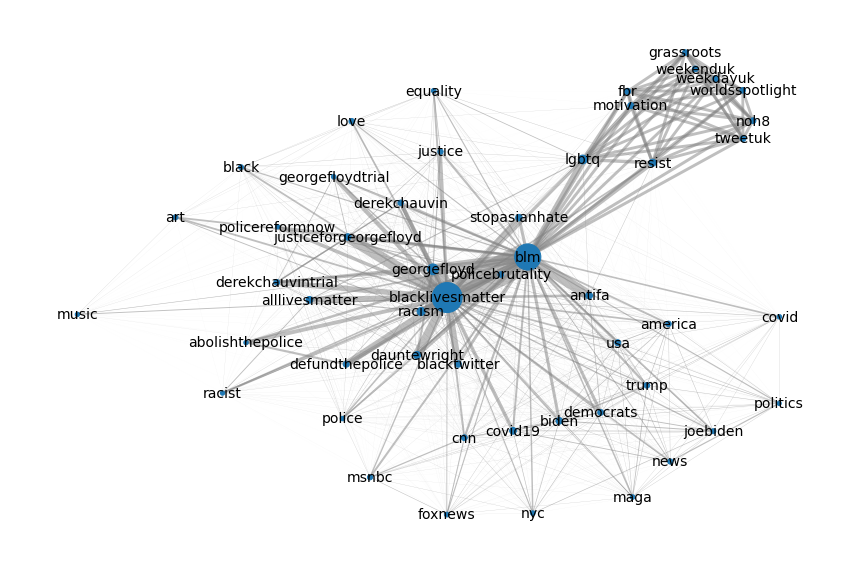

In [29]:
plt.figure(figsize=(12,8))
pos = nx.spring_layout(sub, seed=42) 

# nodes
counts = nx.get_node_attributes(G, 'count')
node_size = [counts[node]//10**2 for node in sub.nodes()]
nx.draw_networkx_nodes(sub, pos, node_size=node_size)

# edges
edge_width = [details['weight']/10**2 for i, j, details in sub.edges(data=True)]
nx.draw_networkx_edges(sub, pos, width=edge_width, 
                       edge_color='grey', alpha=0.5)


# labels
nx.draw_networkx_labels(sub, pos, 
                        font_size=14)

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Example 2: Named entities in congressional record

Here, we'll take an html text file reflecting a single issue (day) of the [US Congressional Record](https://www.congress.gov/congressional-record). This document reports on all business conducted by both the House and the Senate on a given day. Our data is from June 11, 2021.

We'll assume that we don't know much about the data structure. We want to learn something about how members of congress interact with each other, but we're not sure exactly how this will be presented in the data.

We'll use SpaCy's English language model. See [SpaCy's documentation](https://spacy.io/models) for a list of other language models available. For the purposes of today's excercises we'll use the "small" language model which takes up less memory/disk space but which also contains a smaller vocabulary (eg, known words) and information. For most research, I recommend using the large language model for the most accurate results.

### Text processing and cleaning

In [30]:
# packages we will need for this example
import spacy # for text parsing and tagging
from bs4 import BeautifulSoup # for dealing with html
import networkx as nx # for networks
import numpy as np # for math
import itertools as it # fancy iteration
import matplotlib.pyplot as plt # visualizations

nlp = spacy.load('en_core_web_sm')

# for better performance use the large language model:
# nlp = spacy.load('en_core_web_lg')
# Note this is not available on Google Colab

In [31]:
# load the text file
filename = 'CREC-2020-06-11.txt'

with open(filename, 'r') as fp:
    raw_text = fp.read()

In [32]:
# look at first 5k characters of text
raw_text[:5000]

'<html>\n<head>\n<title>Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)</title>\n</head>\n<body><pre>\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [<a href="https://www.gpo.gov">www.gpo.gov</a>]\n\n\n             H O U S E  O F  R E P R E S E N T A T I V E S\n\n\nVol. 166\n\n\nWASHINGTON, THURSDAY, JUNE 11, 2020\n\nNo. 108\n\n\n</pre></body>\n</html>\n<html>\n<head>\n<title>Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)</title>\n</head>\n<body><pre>\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [<a href="https://www.gpo.gov">www.gpo.gov</a>]\n\n[[Page H2379]]\n\nHouse of Representatives\n\n  The House met at 9 a.m. and was called to order by the Speaker pro \ntempore (Mr. Brown of Maryland

In [33]:
# strip html tags using beautiful soup
clean = BeautifulSoup(raw_text, 'html.parser').text

clean[:1000]

'\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [www.gpo.gov]\n\n\n             H O U S E  O F  R E P R E S E N T A T I V E S\n\n\nVol. 166\n\n\nWASHINGTON, THURSDAY, JUNE 11, 2020\n\nNo. 108\n\n\n\n\n\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [www.gpo.gov]\n\n[[Page H2379]]\n\nHouse of Representatives\n\n  The House met at 9 a.m. and was called to order by the Speaker pro \ntempore (Mr. Brown of Maryland).\n\n                          ____________________\n\n\n\n\n\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Numb

In [34]:
# turn into a Spacy document
doc = nlp(clean)
print(doc)



Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H2379]
From the Congressional Record Online through the Government Publishing Office [www.gpo.gov]


             H O U S E  O F  R E P R E S E N T A T I V E S


Vol. 166


WASHINGTON, THURSDAY, JUNE 11, 2020

No. 108






Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H2379]
From the Congressional Record Online through the Government Publishing Office [www.gpo.gov]

[[Page H2379]]

House of Representatives

  The House met at 9 a.m. and was called to order by the Speaker pro 
tempore (Mr. Brown of Maryland).

                          ____________________






Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H237

In [35]:
# 'doc' is now a spacy document
type(doc)

spacy.tokens.doc.Doc

SpaCy now stores this text as essentially a series of "tokens". Tokens are strings of arbitrary length that form a
"building block" of a given language. They can be words, punctuation, white space, etc

In [36]:
# print first 10 tokens 
# Tokens includes white space!
for i, token in enumerate(doc):
    if i < 10:
        print(token.text)




Congressional
Record
,
Volume
166
Issue
108
(
Thursday


In [37]:
# we can also see how many total tokens there are using len()
print('The doc has {} tokens'.format(len(doc)))

The doc has 31727 tokens


SpaCy also stores information about each of these tokens. You can see a list of all available token attributes [here](https://spacy.io/api/token#attributes). Here are a few core ones:
* token.text : string of token
* token.lower_ : lowercase form of the token
* token.lemma_ : base form of token 
* token.pos_ : coarse-grained part-of-speech from the [Universal POS tag set](https://universaldependencies.org/docs/u/pos/)
* token.tag_ : fine-grained part-of-speech
* token.sentiment : sentiment (use carefully!!)
* token.is_stop : boolean indicating if stop word
* token.is_digit : boolean indicating if digit
* token.vector : word embedding (length 300 vector)

In [38]:
for i, token in enumerate(doc):
    if i > 1000 and i < 1010:
        print(token.text)
        print('  index in document: ', token.i)
        print('  lemma: ', token.lemma_)
        print('  Part of speech: ', token.pos_)
        print('  Stop word?', token.is_stop)
        print()

.
  index in document:  1001
  lemma:  .
  Part of speech:  PUNCT
  Stop word? False

The
  index in document:  1002
  lemma:  the
  Part of speech:  DET
  Stop word? True

Chair
  index in document:  1003
  lemma:  Chair
  Part of speech:  PROPN
  Stop word? False

announces
  index in document:  1004
  lemma:  announce
  Part of speech:  VERB
  Stop word? False

the
  index in document:  1005
  lemma:  the
  Part of speech:  DET
  Stop word? True

Speaker
  index in document:  1006
  lemma:  Speaker
  Part of speech:  PROPN
  Stop word? False

's
  index in document:  1007
  lemma:  's
  Part of speech:  PART
  Stop word? True



  index in document:  1008
  lemma:  

  Part of speech:  SPACE
  Stop word? False

appointment
  index in document:  1009
  lemma:  appointment
  Part of speech:  NOUN
  Stop word? False



In [39]:
# recover token from index
doc[1009]

appointment

### Working with named entities

We want to know something about members of Congress, but how do we know which words refer to the people we are interested in?

Use `.ents` to retieve all items labeled as entities. The SpaCy language model we loaded was trained on a large corpus of English language text and is able to somewhat accurately identify many named entitities (the large language model has an accuracy of about 85\%). For most datasets and research questions, **you should (1) verify the accuracy with a random, hand-coded sample, (2) expect to add domain-specific entities not included in SpaCy's model and (3) plan some process of name disambiguation.**

In [40]:
# get all entities in the doc
all_ents = doc.ents
print('{} entities found'.format(len(all_ents)))

3881 entities found


In [41]:
# prin the entity, its label and what character span it occurs in
# Does pretty well, but definitely some weird things in this output!
for ent in all_ents:
    print(ent.text, ent.label_)
    print('   starts at: {}, ends at: {}'.format(ent.start_char, ent.end_char))

166 CARDINAL
   starts at: 31, ends at: 34
Thursday, June 11, 2020 DATE
   starts at: 46, ends at: 69
166 CARDINAL
   starts at: 102, ends at: 105
108 CARDINAL
   starts at: 114, ends at: 117
Thursday, June 11, 2020 DATE
   starts at: 119, ends at: 142
the Congressional Record Online ORG
   starts at: 171, ends at: 202
the Government Publishing Office ORG
   starts at: 211, ends at: 243
166 CARDINAL
   starts at: 326, ends at: 329
WASHINGTON GPE
   starts at: 332, ends at: 342
THURSDAY GPE
   starts at: 344, ends at: 352
JUNE 11, 2020 DATE
   starts at: 354, ends at: 367
108 CARDINAL
   starts at: 373, ends at: 376
Congressional Record ORG
   starts at: 383, ends at: 403
166 CARDINAL
   starts at: 412, ends at: 415
Thursday, June 11, 2020 DATE
   starts at: 427, ends at: 450
166 CARDINAL
   starts at: 483, ends at: 486
108 CARDINAL
   starts at: 495, ends at: 498
Thursday, June 11, 2020 DATE
   starts at: 500, ends at: 523
the Congressional Record Online ORG
   starts at: 552, ends at:

843 CARDINAL
   starts at: 43177, ends at: 43180
P.L. GPE
   starts at: 43212, ends at: 43216
1,771,612 CARDINAL
   starts at: 43297, ends at: 43306
P.L. GPE
   starts at: 43372, ends at: 43376
P.L.
  ORG
   starts at: 43538, ends at: 43544
2020 DATE
   starts at: 43702, ends at: 43706
2020 DATE
   starts at: 43865, ends at: 43869
Section 124 of the Continuing Appropriations Act LAW
   starts at: 44187, ends at: 44235
2020 DATE
   starts at: 44237, ends at: 44241
the Subcommittee on Defense ORG
   starts at: 44369, ends at: 44396
September 27, 2019 DATE
   starts at: 44524, ends at: 44542
May 3, 2019 DATE
   starts at: 44549, ends at: 44560
the House Committee on the Budget ORG
   starts at: 44574, ends at: 44607
fiscal year 2020 DATE
   starts at: 44666, ends at: 44682
H. Res PERSON
   starts at: 44695, ends at: 44701
293 CARDINAL
   starts at: 44703, ends at: 44706
314 CARDINAL
   starts at: 44735, ends at: 44738
the Congressional
  Budget Act ORG
   starts at: 44742, ends at: 44772


2,759.35 CARDINAL
   starts at: 73308, ends at: 73316
Jennifer Hendrixson White PERSON
   starts at: 73317, ends at: 73342
1/18 CARDINAL
   starts at: 73361, ends at: 73365
Brazil GPE
   starts at: 73380, ends at: 73386
575.00 CARDINAL
   starts at: 73425, ends at: 73431
3,159.89 CARDINAL
   starts at: 73449, ends at: 73457
379.00 CARDINAL
   starts at: 73477, ends at: 73483
1/23 CARDINAL
   starts at: 73566, ends at: 73570
Chile GPE
   starts at: 73573, ends at: 73578
652.00 CARDINAL
   starts at: 73618, ends at: 73624
2,532.00 CARDINAL
   starts at: 73694, ends at: 73702
1/23 CARDINAL
   starts at: 73747, ends at: 73751
1/27 CARDINAL
   starts at: 73759, ends at: 73763
Peru GPE
   starts at: 73766, ends at: 73770
823.40 CARDINAL
   starts at: 73811, ends at: 73817
625.82 CARDINAL
   starts at: 73863, ends at: 73869
Brendan Shields PERSON
   starts at: 73896, ends at: 73911
1/19 CARDINAL
   starts at: 73940, ends at: 73944
1/21 CARDINAL
   starts at: 73952, ends at: 73956
Brazil GPE
 

251 CARDINAL
   starts at: 88542, ends at: 88545
110 CARDINAL
   starts at: 88548, ends at: 88551
868 CARDINAL
   starts at: 88558, ends at: 88561
the Committee on Natural Resources ORG
   starts at: 88573, ends at: 88607
Branch PERSON
   starts at: 88654, ends at: 88660
Foreign Species ORG
   starts at: 88684, ends at: 88699
U.S. Fish and Wildlife Service ORG
   starts at: 88701, ends at: 88731
Department ORG
   starts at: 88784, ends at: 88794
Endangered and Threatened Wildlife and Plants ORG
   starts at: 88817, ends at: 88862
the Federal List of 
     Endangered and Threatened Wildlife [Docket No ORG
   starts at: 88902, ends at: 88973
R1-ES-
      PERSON
   starts at: 88980, ends at: 88992
2007-0024 DATE
   starts at: 88992, ends at: 89001
92220-1113-0000-C6 DATE
   starts at: 89003, ends at: 89021
22, 2020 DATE
   starts at: 89059, ends at: 89067
5 CARDINAL
   starts at: 89081, ends at: 89082
121 CARDINAL
   starts at: 89125, ends at: 89128
Sec PERSON
   starts at: 89130, ends at

19 CARDINAL
   starts at: 101851, ends at: 101853
2120 CARDINAL
   starts at: 101868, ends at: 101872
May 22, 2020 DATE
   starts at: 101894, ends at: 101906
5 CARDINAL
   starts at: 101920, ends at: 101921
Sec PERSON
   starts at: 101969, ends at: 101972
251 CARDINAL
   starts at: 101974, ends at: 101977
110 CARDINAL
   starts at: 101980, ends at: 101983
868 CARDINAL
   starts at: 101990, ends at: 101993
the 
     Committee on Transportation and Infrastructure ORG
   starts at: 101999, ends at: 102055
the Management and Program Analyst ORG
   starts at: 102084, ends at: 102118
FAA ORG
   starts at: 102126, ends at: 102129
Department of Transportation ORG
   starts at: 102131, ends at: 102159
the 
     Department's ORG
   starts at: 102174, ends at: 102196
Amendment of VOR Federal Airways ORG
   starts at: 102211, ends at: 102243
V-56 PRODUCT
   starts at: 102250, ends at: 102254
V-209 ORG
   starts at: 102260, ends at: 102265
Airspace Docket ORG
   starts at: 102331, ends at: 102346
1

H.R. 7157 ORG
   starts at: 114237, ends at: 114246
Training Corps ORG
   starts at: 114331, ends at: 114345
the Committee on 
     Armed Services ORG
   starts at: 114466, ends at: 114503
BROWN PERSON
   starts at: 114523, ends at: 114528
Maryland GPE
   starts at: 114532, ends at: 114540
Hoyer PERSON
   starts at: 114559, ends at: 114564
Ms. ORG
   starts at: 114566, ends at: 114569
Sewell of Alabama ORG
   starts at: 114584, ends at: 114601
Kuster PERSON
   starts at: 114607, ends at: 114613
New Hampshire GPE
   starts at: 114617, ends at: 114630
Blunt Rochester PERSON
   starts at: 114654, ends at: 114669
H.R. 7158 PERSON
   starts at: 114679, ends at: 114688
the Committee on Energy and Commerce ORG
   starts at: 114881, ends at: 114917
the Committee on Ways and Means ORG
   starts at: 114944, ends at: 114975
BUSTOS PERSON
   starts at: 115183, ends at: 115189
Wild PERSON
   starts at: 115211, ends at: 115215
H.R. 7159 PERSON
   starts at: 115225, ends at: 115234
the Community Ment

   starts at: 126712, ends at: 126718
Katko PERSON
   starts at: 126738, ends at: 126743
Espaillat PERSON
   starts at: 126749, ends at: 126758
Brindisi PERSON
   starts at: 126764, ends at: 126772
Malinowski PERSON
   starts at: 126792, ends at: 126802
Payne PERSON
   starts at: 126808, ends at: 126813
Gottheimer PERSON
   starts at: 126819, ends at: 126829
Fitzpatrick PERSON
   starts at: 126849, ends at: 126860
Dean PERSON
   starts at: 126866, ends at: 126870
Norton PERSON
   starts at: 126880, ends at: 126886
36 CARDINAL
   starts at: 126950, ends at: 126952
United States Code GPE
   starts at: 126954, ends at: 126972
the Freedom Flag LAW
   starts at: 126993, ends at: 127009
United States GPE
   starts at: 127045, ends at: 127058
September 11, 2001 DATE
   starts at: 127136, ends at: 127154
the Committee on the Judiciary ORG
   starts at: 127189, ends at: 127219
STEUBE PERSON
   starts at: 127239, ends at: 127245
the Committee on Ways and Means ORG
   starts at: 127404, ends at: 

Article I, Section 8 LAW
   starts at: 140858, ends at: 140878
18 CARDINAL
   starts at: 140893, ends at: 140895
166 CARDINAL
   starts at: 140931, ends at: 140934
Thursday, June 11, 2020 DATE
   starts at: 140946, ends at: 140969
166 CARDINAL
   starts at: 141002, ends at: 141005
108 CARDINAL
   starts at: 141014, ends at: 141017
Thursday, June 11, 2020 DATE
   starts at: 141019, ends at: 141042
the Congressional Record Online ORG
   starts at: 141071, ends at: 141102
the Government Publishing Office ORG
   starts at: 141111, ends at: 141143
CLARKE PERSON
   starts at: 141177, ends at: 141183
New York GPE
   starts at: 141187, ends at: 141195
Congress ORG
   starts at: 141222, ends at: 141230
Article 1, Section 8





Congressional Record LAW
   starts at: 141311, ends at: 141357
166 CARDINAL
   starts at: 141366, ends at: 141369
Thursday, June 11, 2020 DATE
   starts at: 141381, ends at: 141404
166 CARDINAL
   starts at: 141437, ends at: 141440
108 CARDINAL
   starts at: 141449, ends

Congressional Record LAW
   starts at: 156577, ends at: 156619
166 CARDINAL
   starts at: 156628, ends at: 156631
Thursday, June 11, 2020 DATE
   starts at: 156643, ends at: 156666
166 CARDINAL
   starts at: 156699, ends at: 156702
108 CARDINAL
   starts at: 156711, ends at: 156714
Thursday, June 11, 2020 DATE
   starts at: 156716, ends at: 156739
the Congressional Record Online ORG
   starts at: 156768, ends at: 156799
the Government Publishing Office ORG
   starts at: 156808, ends at: 156840
CARSON PERSON
   starts at: 156874, ends at: 156880
Indiana GPE
   starts at: 156884, ends at: 156891
Congress ORG
   starts at: 156918, ends at: 156926
18 CARDINAL
   starts at: 157014, ends at: 157016
Article I of the Constitution LAW
   starts at: 157033, ends at: 157062
Congressional Record ORG
   starts at: 157069, ends at: 157089
166 CARDINAL
   starts at: 157098, ends at: 157101
Thursday, June 11, 2020 DATE
   starts at: 157113, ends at: 157136
166 CARDINAL
   starts at: 157169, ends at: 1

   starts at: 162255, ends at: 162273
New York GPE
   starts at: 162277, ends at: 162285
H.R. 1705 DATE
   starts at: 162294, ends at: 162303
Carbajal PERSON
   starts at: 162309, ends at: 162317
H.R. 1714 DATE
   starts at: 162326, ends at: 162335
Larsen PERSON
   starts at: 162341, ends at: 162347
Washington GPE
   starts at: 162351, ends at: 162361
Deutch PERSON
   starts at: 162370, ends at: 162376
H.R. 1733 DATE
   starts at: 162385, ends at: 162394
Quigley PERSON
   starts at: 162400, ends at: 162407
Eshoo PERSON
   starts at: 162413, ends at: 162418
Langevin PERSON
   starts at: 162428, ends at: 162436
Castor PERSON
   starts at: 162460, ends at: 162466
Florida GPE
   starts at: 162470, ends at: 162477
Beatty PERSON
   starts at: 162487, ends at: 162493
1975 DATE
   starts at: 162507, ends at: 162511
Pappas PERSON
   starts at: 162528, ends at: 162534
Hartzler PERSON
   starts at: 162541, ends at: 162549
Mitchell PERSON
   starts at: 162565, ends at: 162573
H.R. 1997 DATE
   sta

Maryland GPE
   starts at: 167974, ends at: 167982
Adams PERSON
   starts at: 167988, ends at: 167993
Gallego PERSON
   starts at: 167999, ends at: 168006
Brendan F. Boyle PERSON
   starts at: 168018, ends at: 168034
Pennsylvania GPE
   starts at: 168038, ends at: 168050
Sarbanes PERSON
   starts at: 168060, ends at: 168068
Ruiz PERSON
   starts at: 168092, ends at: 168096
Cisneros PERSON
   starts at: 168120, ends at: 168128
Ruiz PERSON
   starts at: 168152, ends at: 168156
Garamendi PERSON
   starts at: 168165, ends at: 168174
H.R. 6698 PERSON
   starts at: 168183, ends at: 168192
Haaland PERSON
   starts at: 168198, ends at: 168205
Rouda PERSON
   starts at: 168229, ends at: 168234
Schakowsky PERSON
   starts at: 168240, ends at: 168250
Castor PERSON
   starts at: 168260, ends at: 168266
Florida GPE
   starts at: 168276, ends at: 168283
Nadler PERSON
   starts at: 168307, ends at: 168313
Kennedy PERSON
   starts at: 168337, ends at: 168344
H.R. 6726 PERSON
   starts at: 168353, ends

Garcia PERSON
   starts at: 174623, ends at: 174629
Adams PERSON
   starts at: 174653, ends at: 174658
DeFazio PERSON
   starts at: 174664, ends at: 174671
Castor PERSON
   starts at: 174677, ends at: 174683
Florida GPE
   starts at: 174687, ends at: 174694
Hastings PERSON
   starts at: 174710, ends at: 174718
H.R. 7136 PERSON
   starts at: 174727, ends at: 174736
San Nicolas PERSON
   starts at: 174742, ends at: 174753
Clarke PERSON
   starts at: 174777, ends at: 174783
New York GPE
   starts at: 174787, ends at: 174795
Castor PERSON
   starts at: 174801, ends at: 174807
Florida GPE
   starts at: 174811, ends at: 174818
Tlaib PERSON
   starts at: 174830, ends at: 174835
Beyer PERSON
   starts at: 174845, ends at: 174850
H. Con PERSON
   starts at: 174859, ends at: 174865
100 CARDINAL
   starts at: 174872, ends at: 174875
Jeffries PERSON
   starts at: 174881, ends at: 174889
Waters PERSON
   starts at: 174895, ends at: 174901
Green PERSON
   starts at: 174907, ends at: 174912
Texas GPE

In [42]:
# Let's filter to keep just the items that are labeled as "PERSON"
# Note: SpaCy "token" objects are unique, 
# if we want a unique list of names, we need to at the .text of a token

# try 1: keeping tokens
people = set()

for ent in all_ents:
    if ent.label_ == 'PERSON':
        people.add(ent) # keep the token object
        
print('{} unique people tokens founds'.format(len(people)))

# try 2: keeping just text
people = set()

for ent in all_ents:
    if ent.label_ == 'PERSON':
        people.add(ent.text) # keep just the text
        
print('{} unique people tokens founds'.format(len(people)))

1166 unique people tokens founds
477 unique people tokens founds


In [43]:
# look at what we get...
people

{'4420',
 'ARRINGTON',
 'Adams',
 'Aderholt',
 'Airway V-61',
 'Albio Sires',
 'Alex Sadler',
 'Alexander Brockwehl',
 'Allred',
 'Ami Bera',
 'Anthony G. Brown',
 'Axne',
 'BANKS',
 'BEYER',
 'BISHOP',
 'BRENDAN F. BOYLE',
 'BROWN',
 'BUSTOS',
 'BUTTERFIELD',
 'Babin',
 'Bacon',
 'Balderson',
 'Banks',
 'Barragan',
 'Beatty',
 'Bera',
 'Beutler',
 'Beyer',
 'Bishop',
 'Blumenauer',
 'Blunt',
 'Blunt Rochester',
 'Bombardier',
 'Bonamici',
 'Bost',
 'Branch',
 'Brendan F. Boyle',
 'Brendan Shields',
 'Brindisi',
 'Brooks',
 'Brown',
 'Brownley',
 'Buchanan',
 'Budd',
 'Burchett',
 'Burgess',
 'Bustos',
 'Butterfield',
 'Butterfly Plant',
 'Byrne',
 'CARSON',
 'CHENEY',
 'CISNEROS',
 'CLARKE',
 'COVID-19',
 'Calvert',
 'Carbajal',
 'Cardenas',
 'Carlos Monje',
 'Caroline Campbell',
 'Carolyn B. Maloney',
 'Carson',
 'Carter',
 'Cartwright',
 'Case',
 'Casten',
 'Casten of Illinois',
 'Castor',
 'Castro Ramirez',
 'Catherine Feingold',
 'Chris Farrar',
 'Cicilline',
 'Cisneros',
 'Clarke

### Caveat / Disclaimer:
Working with text is hard! Many of these entities are _not_ people, and there's also a need to do entity linking / name disambiguation. Think about what types of validation / verification you need to put in place given your data set!

SpaCy allows you to connect your language to a [knowledge base]{https://spacy.io/api/kb/}, which can help with the task of disambiguation. This can be a custom knowledge base or an existing knowledge base -- eg, WikiData. 

Note also also that only names/titles are tagged as entities. Pronouns are not. If your research question has to do with how a text "talks about" someone, you may need to do additional analysis to identify non-named references to the person of interest.

In [49]:
# House resolutions are being tagged as people. ...Let's drop those.
people = dict()

for ent in all_ents:
    if ent.label_ == 'PERSON' and ent.text[:4] != 'H.R.':
        people.setdefault(ent.text, list())
        people[ent.text].append((ent.start_char, ent.end_char))
        
print('{} unique people tokens founds'.format(len(people)))

428 unique people tokens founds


In [50]:
# look at out dictionary
# keys are people and values are the character strings where they occur

# note again the need for disambiguation -- are "Brown" and "Anthony G. Brown" the same person?
people

{'Brown': [(765, 770),
  (112086, 112091),
  (165905, 165910),
  (166150, 166155),
  (166328, 166333),
  (167965, 167970),
  (170774, 170779)],
 'Anthony G. Brown': [(1421, 1437)],
 'Patrick J. Conroy': [(1984, 2001)],
 'BISHOP': [(3969, 3975)],
 'Catherine Feingold': [(4976, 4994)],
 'Frederick Gibson Ross': [(5024, 5045)],
 'J. REFUGIO': [(5429, 5439), (6013, 6023)],
 'Castro Ramirez': [(5597, 5611),
  (6184, 6198),
  (6604, 6618),
  (7935, 7949),
  (8502, 8516)],
 'J. Refugio Carreno Rojas': [(5616, 5640), (7223, 7247), (8521, 8545)],
 'Clerk': [(5648, 5653), (108415, 108420)],
 'Maria \n     Carmen': [(6165, 6183)],
 'J. Refugio Carreno': [(6203, 6221),
  (6628, 6646),
  (7953, 7971),
  (9215, 9233)],
 'Maria Carmen Castro': [(7185, 7204)],
 'Ramirez': [(7211, 7218)],
 'Maria Carmen': [(7922, 7934), (8483, 8495)],
 'Visa Number.--Upon': [(8398, 8416)],
 'Maria Carmen Castro Ramirez': [(9183, 9210)],
 'Jennifer Wheelock': [(13431, 13448), (51306, 51323)],
 'Raquel Spencer': [(13458,

### let's find sentences which mention people

In [51]:
# First, we get a list of all the start positions mentions of people
person_start = list()

for hr, char_list in people.items():
    for start, end in char_list:
        person_start.append(start)
        
person_start = sorted(person_start)
print(person_start[:10])

[765, 1421, 1984, 3969, 4976, 5024, 5429, 5597, 5616, 5648]


In [52]:
# iterate through the sentence in our document and keep sentences which include
# "the start of a person"
keep = list()

for sent in doc.sents:
    start = sent.start_char  # doc character index of sentence start
    end = sent.end_char  # doc character intexxt of sentence end
    
    for val in person_start: # for each index that represents the start of a "person"
        # keep this sentence if it's in this sentence spane
        if val >= start and val < end:
            keep.append(sent)
            
print('{} sentences kept'.format(len(keep)))

1101 sentences kept


In [53]:
# let's look at some of these sentences...
# Yes, I took an intentional slice here to show sentences of interest
for sent in keep[150:155]:
    print(sent)

By Mr. LATTA:
       H.R. 7147.
By Mr. WILSON of South Carolina (for himself and Ms. 
             Houlahan):
       H.R. 7148.
By Mr. WILSON of South Carolina (for himself and Ms. 
             Houlahan):
       H.R. 7148.

           By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
             Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
             Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
       H.R. 7149.

           By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
             Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
             Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
       H.R. 7149.


### PSA: 
Automated text analysis is **not** a replacement for qualitative analyis, but it can help identify texts/segements of interest from large corpora.

### Making a network
We'll make a co-sponsorship network where two people are connected if they are connected to the same bill. We'll use last names only and assume that all last names are unique. 

For example, given the sentence: "By Mr. WILSON of South Carolina (for himself and Ms. Houlahan)", we'll want a network that has: <br/> `edge: Wilson, Houlahan, weight = 1`

In [54]:
# FIRST, we'll find sentences that have the format we want
# specifically, we're looking for this format:
# "By [Mr./Mrs./Dr.] [Name]"

# find sentences of this format
cosponsored = list()

for sent in keep: # for every sentence we're keeping
    for i, token in enumerate(sent): # keep track of the token and it's position in the sentence
        if token.lemma_ == 'by' and i < len(sent)-2: # if the token is 'by' and we're not at the end of the sentence
            salutation_token = sent[i+1] # save the next token 
            name_token = sent[i+2] # and the token after that
            
            # check the two words immediate after "by"
            # keep this sentence if they're both labled as 'PROPN' (proper nouns)
            # and the "name" field is recognized as a person
            if salutation_token.pos_ == 'PROPN' and name_token.pos_ == 'PROPN' and name_token.ent_type_ == 'PERSON':
                cosponsored.append(sent)
                
print('{} Co-sponsorships sentences found'.format(len(cosponsored)))

321 Co-sponsorships sentences found


In [55]:
# look at the sentences we saved
cosponsored

[By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. LATTA:
        H.R. 7147.,
 By Mr. WILSON of South Carolina (for himself and Ms. 
              Houlahan):
        H.R. 7148.,
 By Mr. WILSON of South Carolina (for himself and Ms. 
              Houlahan):
        H.R. 7148.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
              Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
              Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
        H.R. 7149.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
              Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
              Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
        H.R. 7149.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn

### Make a network

For the purpose of this example will do some very simple (and innacurate name disambiguation rules. We'll assume that the last "name" token is the best label for person (eg, "ocasio-cortez" becomes "cortez") and that all matching last names refer to the same person (eg, every "brown" is the same person). The rules are definitely inducing errors in the data, but we'll use them here for demonstration purposes.

In [56]:
# now we'll make the network!
G = nx.Graph()

for sent in cosponsored:
    names = set()
    
    # get names from this sentence
    for i, token in enumerate(sent):
        next_token = sent[(i+1)%len(sent)]
        
        # take something as a name ONLY if:
        # 1 -- it is a proper noun (this trims weird things labeled as people)
        # 2 -- it is a "person" entity (what we're looking for!)
        # 3 -- the *next* token is NOT a person entity (we only want last name)
        if token.pos_ == 'PROPN' and token.ent_type_ == 'PERSON' and next_token.ent_type_ != 'PERSON' :
            names.add(token.lower_)
            
    # now, we have a set of nodes (people), let's add edges!
    # this code is basically the same as the hashtag code!
    
    names = list(names) # change to list for indexing
    
    # if there's only 1 person, we have a node but no edge
    if len(names) == 1:
        h1 = names[0]
        G.add_node(h1) # add node (won't replace)
        
    else:
        for h1, h2 in it.combinations(names, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
             
print('{} nodes (people) found'.format(len(G)))

175 nodes (people) found


In [57]:
# look at largest connected component
G_c = max(nx.connected_components(G), key=len) # nodes in largest connect component

sub = G.subgraph(G_c).copy() # induce subgraph from this

print(len(sub))

155


In [58]:
# load data about party affiliation
party = dict()

with open('party_affiliation.txt', 'r') as fp:
    for line in fp.readlines():
        line = line.strip().split('\t')
        
        party[line[0]] = line[1]

In [55]:
party

{'aderholt': 'R',
 'allred': 'D',
 'babin': 'R',
 'bacon': 'R',
 'balart': 'R',
 'balderson': 'R',
 'beatty': 'D',
 'bera': 'D',
 'beyer': 'D',
 'bishop': 'R',
 'blunt': 'R',
 'boyle': 'D',
 'brindisi': 'D',
 'brooks': 'R',
 'brown': 'D',
 'brownley': 'D',
 'buchanan': 'R',
 'budd': 'R',
 'burchett': 'R',
 'bustos': 'D',
 'butterfield': 'D',
 'calvert': 'R',
 'carson': 'D',
 'cicilline': 'D',
 'cisneros': 'D',
 'clarke': 'D',
 'cline': 'R',
 'coleman': 'D',
 'collins': 'R',
 'con': 'U',
 'conaway': 'R',
 'connolly': 'D',
 'cook': 'R',
 'cooper': 'D',
 'crawford': 'R',
 'dean': 'D',
 'defazio': 'D',
 'degette': 'D',
 'desaulnier': 'D',
 'dingell': 'D',
 'doyle': 'D',
 'engel': 'D',
 'escobar': 'D',
 'eshoo': 'D',
 'espaillat': 'D',
 'fitzpatrick': 'R',
 'fudge': 'D',
 'gaetz': 'R',
 'garcia': 'D',
 'gibbs': 'R',
 'gottheimer': 'D',
 'griffith': 'R',
 'haaland': 'D',
 'hagedorn': 'R',
 'harris': 'R',
 'hartzler': 'R',
 'hastings': 'D',
 'hayes': 'D',
 'hern': 'R',
 'holding': 'R',
 'hors

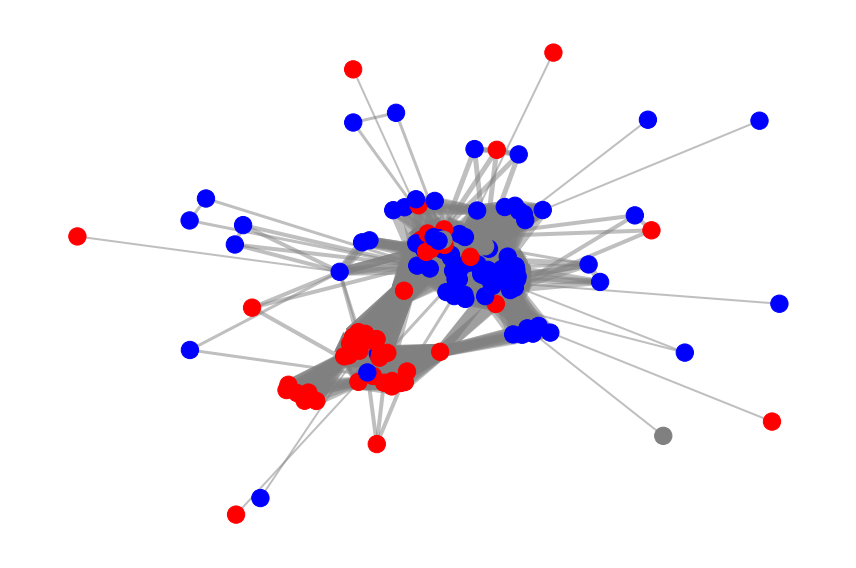

In [59]:
# visualize network
plt.figure(figsize=(12,8))
pos = nx.spring_layout(sub, seed=42) 

# nodes
color = list()
for node in sub.nodes():
    if party[node] == 'D':
        color.append('blue')
    elif party[node] == 'R':
        color.append('red')
    else:
        color.append('grey')
        
nx.draw_networkx_nodes(sub, pos, node_color = color)

# edges
edge_width = [details['weight'] for i, j, details in sub.edges(data=True)]
nx.draw_networkx_edges(sub, pos, width=edge_width, 
                       edge_color='grey', alpha=0.5)


# labels
# nx.draw_networkx_labels(sub, pos, 
#                        font_size=14)

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Example 3 -- Using Word Embeddings and Clustering
In this example, we'll demonstrate how word embeddings and clustering can be used to identify "similar" words and how grammatical structure can indicate connectivity.

**Note: the "small" language model that we're using should NOT be used for word embeddings.** We'll continue to use it here for the purposes of demonstration, but we'll see some warnings pop up and our results will be very weird/bad. Use the "large" language model when working with embeddings!

In [61]:
# packages we'll need
from sklearn.cluster import KMeans  # for clustering
from sklearn.decomposition import PCA # for dimensionality reduction
from kneed import KneeLocator # for identifying the "elbow"

In [62]:
# load plain text
filename = 'King_BirminghamJail.txt'

with open(filename, 'r') as fp:
    raw_text = fp.read()
    
# turn into a Spacy document
doc = nlp(raw_text)
print(doc)

"Letter from a Birmingham Jail [King, Jr.]"

16 April 1963
My Dear Fellow Clergymen:
While confined here in the Birmingham city jail, I came across your recent statement calling my present activities "unwise and untimely." Seldom do I pause to answer criticism of my work and ideas. If I sought to answer all the criticisms that cross my desk, my secretaries would have little time for anything other than such correspondence in the course of the day, and I would have no time for constructive work. But since I feel that you are men of genuine good will and that your criticisms are sincerely set forth, I want to try to answer your statement in what I hope will be patient and reasonable terms.

I think I should indicate why I am here in Birmingham, since you have been influenced by the view which argues against "outsiders coming in." I have the honor of serving as president of the Southern Christian Leadership Conference, an organization operating in every southern state, with headquarters i

In [45]:
# Let's only keep tokens which reflect "interesting" parts of speech. We'll arbitarily define that as:

POS_keep = set(['ADJ',
               'ADV',
               'NOUN',
               'PROPN',
               'VERB'])

# note: checking for membership in a set is faster than checking for membership in a list

In [46]:
# keep just tokens with these parts of speech
trimmed = list()

for token in doc:
    if token.pos_ in POS_keep:
        trimmed.append(token)
        
print('Started with {} tokens'.format(len(doc)))
print('Kept {} tokens'.format(len(trimmed)))

unique_words = set([token.lower_ for token in trimmed])
print('{} unique words found'.format(len(unique_words)))

Started with 31727 tokens
Kept 11905 tokens
2061 unique words found


In [47]:
# take a look and index each item
for i, val in enumerate(trimmed):
    print(i, val)

0 Congressional
1 Record
2 Volume
3 Issue
4 Thursday
5 June
6 Congressional
7 Record
8 Volume
9 Number
10 Thursday
11 June
12 House
13 Page
14 H2379
15 Congressional
16 Record
17 Online
18 Government
19 Publishing
20 Office
21 H
22 U
23 S
24 E
25 F
26 R
27 E
28 P
29 R
30 E
31 S
32 E
33 N
34 T
35 A
36 T
37 I
38 V
39 E
40 S
41 Vol
42 WASHINGTON
43 THURSDAY
44 JUNE
45 .
46 Congressional
47 Record
48 Volume
49 Issue
50 Thursday
51 June
52 Congressional
53 Record
54 Volume
55 Number
56 Thursday
57 June
58 House
59 Page
60 H2379
61 Congressional
62 Record
63 Online
64 Government
65 Publishing
66 Office
67 Page
68 H2379
69 House
70 Representatives
71 House
72 met
73 a.m.
74 called
75 order
76 Speaker
77 pro
78 tempore
79 Mr.
80 Brown
81 Maryland
82 Congressional
83 Record
84 Volume
85 Issue
86 Thursday
87 June
88 Congressional
89 Record
90 Volume
91 Number
92 Thursday
93 June
94 House
95 Page
96 H2379
97 Congressional
98 Record
99 Online
100 Government
101 Publishing
102 Office
103 DESIGNATIO

928 spending
929 limits
930 section
931 251(b
932 Balanced
933 Budget
934 Emergency
935 Deficit
936 Control
937 Act
938 Table
939 compares
940 current
941 levels
942 budget
943 authority
944 outlays
945 legislative
946 action
947 completed
948 authorizing
949 committee
950 limits
951 filed
952 Congressional
953 Record
954 May
955 fiscal
956 year
957 comparisons
958 needed
959 enforce
960 point
961 order
962 section
963 302(f
964 Congressional
965 Budget
966 Act
967 prohibits
968 consideration
969 measures
970 breach
971 section
972 302(a
973 allocation
974 new
975 budget
976 authority
977 committee
978 reported
979 measure
980 also
981 needed
982 implement
983 section
984 311(c
985 provides
986 exception
987 committees
988 comply
989 allocations
990 point
991 order
992 section
993 311(a
994 Table
995 displays
996 current
997 level
998 advance
999 appropriations
1000 fiscal
1001 year
1002 appropriations
1003 bills
1004 table
1005 needed
1006 enforce
1007 rule
1008 appropriations
1009 bi

1678 estimates
1679 budget
1680 authority
1681 outlays
1682 revenues
1683 consistent
1684 allocations
1685 aggregates
1686 other
1687 budgetary
1688 levels
1689 printed
1690 Congressional
1691 Record
1692 May
1693 adjusted
1694 pursuant
1695 sections
1696 House
1697 Resolution
1698 116th
1699 Congress
1700 last
1701 letter
1702 dated
1703 January
1704 Congress
1705 cleared
1706 President
1707 signed
1708 following
1709 legislation
1710 has
1711 significant
1712 effects
1713 budget
1714 authority
1715 outlays
1716 revenues
1717 fiscal
1718 year
1719 United
1720 States
1721 Mexico
1722 Canada
1723 Agreement
1724 Implementation
1725 Act
1726 Public
1727 Law
1728 Coronavirus
1729 Preparedness
1730 Response
1731 Supplemental
1732 Appropriations
1733 Act
1734 Public
1735 Law
1736 Families
1737 First
1738 Coronavirus
1739 Response
1740 Act
1741 Public
1742 Law
1743 act
1744 make
1745 technical
1746 corrections
1747 Guam
1748 World
1749 War
1750 II
1751 Loyalty
1752 Recognition
1753 Act
1754 P

2427 Office
2428 PUBLICATION
2429 BUDGETARY
2430 MATERIAL
2431 STATUS
2432 REPORT
2433 ON
2434 CURRENT
2435 LEVELS
2436 ON
2437 BUDGET
2438 SPENDING
2439 REVENUES
2440 FY
2441 House
2442 Representatives
2443 Committee
2444 Budget
2445 Washington
2446 DC
2447 June
2448 Dear
2449 Madam
2450 Speaker
2451 facilitate
2452 application
2453 sections
2454 Congressional
2455 Budget
2456 Act
2457 transmitting
2458 updated
2459 status
2460 report
2461 current
2462 levels
2463 budget
2464 spending
2465 revenues
2466 fiscal
2467 year
2468 status
2469 report
2470 current
2471 June
2472 term
2473 current
2474 level
2475 refers
2476 amounts
2477 spending
2478 revenues
2479 estimated
2480 fiscal
2481 year
2482 based
2483 laws
2484 enacted
2485 awaiting
2486 President
2487 signature
2488 Table
2489 compares
2490 current
2491 levels
2492 total
2493 budget
2494 authority
2495 outlays
2496 revenues
2497 overall
2498 limits
2499 filed
2500 Congressional
2501 Record
2502 May
2503 fiscal
2504 year
2505 year
2

3426 OFFICIAL
3427 FOREIGN
3428 TRAVEL
3429 COMMITTEE
3430 ON
3431 FOREIGN
3432 AFFAIRS
3433 U.S.
3434 HOUSE
3435 REPRESENTATIVES
3436 EXPENDED
3437 JAN
3438 MAR
3439 Date
3440 diem
3441 \1\
3442 Transportation
3443 Other
3444 purposes
3445 Total
3446 -------------------------------------------------------------------------------------------------------
3447 U.S.
3448 dollar
3449 U.S.
3450 dollar
3451 U.S.
3452 dollar
3453 U.S.
3454 dollar
3455 Name
3456 Member
3457 employee
3458 Country
3459 Foreign
3460 equivalent
3461 Foreign
3462 equivalent
3463 Foreign
3464 equivalent
3465 Foreign
3466 equivalent
3467 Arrival
3468 Departure
3469 currency
3470 U.S.
3471 currency
3472 U.S.
3473 currency
3474 U.S.
3475 currency
3476 U.S.
3477 currency
3478 currency
3479 currency
3480 currency
3481 -----------------------------------------------------------------------------------------------------------\2\-----------------------\2\-----------------------\2\-----------------------\2\----
3482 Hon
3483

4426 Identifier
4427 NM-155
4428 AD
4429 Amendment
4430 AD
4431 RIN
4432 AA64
4433 received
4434 May
4435 pursuant
4436 U.S.C.
4437 801(a)(1)(A
4438 Public
4439 Law
4440 Sec
4441 Stat
4442 Committee
4443 Transportation
4444 Infrastructure
4445 letter
4446 Management
4447 Program
4448 Analyst
4449 FAA
4450 Department
4451 Transportation
4452 transmitting
4453 Department
4454 final
4455 rule
4456 Airworthiness
4457 Directives
4458 Airbus
4459 Canada
4460 Limited
4461 Partnership
4462 Type
4463 Certificate
4464 Previously
4465 Held
4466 C
4467 Series
4468 Aircraft
4469 Limited
4470 Partnership
4471 CSALP
4472 Bombardier
4473 Inc.
4474 Airplanes
4475 Docket
4476 FAA-2019
4477 Product
4478 Identifier
4479 NM-175
4480 AD
4481 Amendment
4482 AD
4483 RIN
4484 AA64
4485 received
4486 May
4487 pursuant
4488 U.S.C.
4489 801(a)(1)(A
4490 Public
4491 Law
4492 Sec
4493 Stat
4494 Committee
4495 Transportation
4496 Infrastructure
4497 letter
4498 Management
4499 Program
4500 Analyst
4501 FAA
4502 Depa

5563 Corporations
5564 Stock
5565 Indebtedness
5566 TD
5567 RIN
5568 1545-
5569 BN68
5570 received
5571 May
5572 pursuant
5573 U.S.C.
5574 801(a)(1)(A
5575 Public
5576 Law
5577 Sec
5578 Stat
5579 Committee
5580 Ways
5581 Means
5582 Congressional
5583 Record
5584 Volume
5585 Issue
5586 Thursday
5587 June
5588 Congressional
5589 Record
5590 Volume
5591 Number
5592 Thursday
5593 June
5594 House
5595 Page
5596 H2387
5597 Congressional
5598 Record
5599 Online
5600 Government
5601 Publishing
5602 Office
5603 REPORTS
5604 COMMITTEES
5605 PUBLIC
5606 BILLS
5607 RESOLUTIONS
5608 clause
5609 rule
5610 XIII
5611 reports
5612 committees
5613 delivered
5614 Clerk
5615 printing
5616 reference
5617 proper
5618 calendar
5619 follows
5620 Mr.
5621 GRIJALVA
5622 Committee
5623 Natural
5624 Resources
5625 H.R.
5626 bill
5627 require
5628 Secretary
5629 Interior
5630 conduct
5631 special
5632 resource
5633 study
5634 sites
5635 associated
5636 life
5637 legacy
5638 noted
5639 American
5640 philanthropist


6745 Mr.
6746 Brindisi
6747 Mr.
6748 Joyce
6749 Pennsylvania
6750 H.R.
6751 bill
6752 modify
6753 calculation
6754 maximum
6755 loan
6756 amount
6757 certain
6758 farmers
6759 ranchers
6760 paycheck
6761 protection
6762 program
6763 Small
6764 Business
6765 Administration
6766 other
6767 purposes
6768 Committee
6769 Small
6770 Business
6771 Mrs.
6772 LURIA
6773 H.R.
6774 bill
6775 amend
6776 title
6777 United
6778 States
6779 Code
6780 improve
6781 dependent
6782 coverage
6783 TRICARE
6784 Young
6785 Adult
6786 Program
6787 other
6788 purposes
6789 Committee
6790 Armed
6791 Services
6792 Mr.
6793 LYNCH
6794 H.R.
6795 bill
6796 require
6797 joint
6798 task
6799 force
6800 air
6801 travel
6802 COVID-19
6803 Public
6804 Health
6805 Emergency
6806 other
6807 purposes
6808 Committee
6809 Transportation
6810 Infrastructure
6811 addition
6812 Committees
6813 Homeland
6814 Security
6815 Energy
6816 Commerce
6817 period
6818 subsequently
6819 determined
6820 Speaker
6821 case
6822 consideration

7680 expressing
7681 support
7682 designation
7683 July
7684 Collector
7685 Car
7686 Appreciation
7687 Day
7688 recognizing
7689 collection
7690 restoration
7691 historic
7692 classic
7693 cars
7694 important
7695 part
7696 preserving
7697 technological
7698 achievements
7699 cultural
7700 heritage
7701 United
7702 States
7703 Committee
7704 Oversight
7705 Reform
7706 Ms.
7707 SCANLON
7708 Mr.
7709 Schiff
7710 Ms.
7711 Norton
7712 Mr.
7713 Vargas
7714 Mrs.
7715 Hayes
7716 Mrs.
7717 Beatty
7718 Mr.
7719 Rush
7720 Mr.
7721 Raskin
7722 Mr.
7723 Cooper
7724 Mr.
7725 Welch
7726 Mr.
7727 Hastings
7728 Mr.
7729 McGovern
7730 Mr.
7731 Neguse
7732 Mr.
7733 Cicilline
7734 Mr.
7735 Huffman
7736 Mr.
7737 San
7738 Nicolas
7739 Ms.
7740 Houlahan
7741 Ms.
7742 Eshoo
7743 H.
7744 Res
7745 resolution
7746 recognizing
7747 threats
7748 press
7749 freedom
7750 United
7751 States
7752 wake
7753 protests
7754 following
7755 killing
7756 George
7757 Floyd
7758 unarmed
7759 Black
7760 man
7761 police
7762 Mi

8683 power
8684 enact
8685 legislation
8686 pursuant
8687 following
8688 Protection
8689 Civilians
8690 Military
8691 Operations
8692 Act
8693 Article
8694 Section
8695 Constitution
8696 gives
8697 Congress
8698 power
8699 make
8700 laws
8701 are
8702 necessary
8703 proper
8704 carry
8705 enumerated
8706 powers
8707 Congressional
8708 Record
8709 Volume
8710 Issue
8711 Thursday
8712 June
8713 Congressional
8714 Record
8715 Volume
8716 Number
8717 Thursday
8718 June
8719 House
8720 Page
8721 Congressional
8722 Record
8723 Online
8724 Government
8725 Publishing
8726 Office
8727 Mr.
8728 KIND
8729 H.R.
8730 Congress
8731 has
8732 power
8733 enact
8734 legislation
8735 pursuant
8736 following
8737 Article
8738 Section
8739 Clause
8740 Congressional
8741 Record
8742 Volume
8743 Issue
8744 Thursday
8745 June
8746 Congressional
8747 Record
8748 Volume
8749 Number
8750 Thursday
8751 June
8752 House
8753 Page
8754 Congressional
8755 Record
8756 Online
8757 Government
8758 Publishing
8759 Office

9646 Volume
9647 Number
9648 Thursday
9649 June
9650 House
9651 Page
9652 Congressional
9653 Record
9654 Online
9655 Government
9656 Publishing
9657 Office
9658 Ms.
9659 WATERS
9660 H.R.
9661 Congress
9662 has
9663 power
9664 enact
9665 legislation
9666 pursuant
9667 following
9668 Article
9669 Section
9670 U.S.
9671 Constitution
9672 Congressional
9673 Record
9674 Volume
9675 Issue
9676 Thursday
9677 June
9678 Congressional
9679 Record
9680 Volume
9681 Number
9682 Thursday
9683 June
9684 House
9685 Page
9686 Congressional
9687 Record
9688 Online
9689 Government
9690 Publishing
9691 Office
9692 Mr.
9693 WITTMAN
9694 H.R.
9695 Congress
9696 has
9697 power
9698 enact
9699 legislation
9700 pursuant
9701 following
9702 Article
9703 I
9704 Section
9705 Clause
9706 Congress
9707 have
9708 power
9709 make
9710 Laws
9711 be
9712 necessary
9713 proper
9714 carrying
9715 Execution
9716 foregoing
9717 Powers
9718 other
9719 Powers
9720 vested
9721 Constitution
9722 Government
9723 United
9724 Sta

10509 Stauber
10510 H.R.
10511 Mr.
10512 Soto
10513 H.R.
10514 Mrs.
10515 Axne
10516 H.R.
10517 Mrs.
10518 Bustos
10519 H.R.
10520 Ms.
10521 Finkenauer
10522 H.R.
10523 Mrs.
10524 Davis
10525 California
10526 H.R.
10527 Mr.
10528 Van
10529 Drew
10530 H.R.
10531 Mr.
10532 Mullin
10533 Mr.
10534 Cohen
10535 H.R.
10536 Ms.
10537 Underwood
10538 H.R.
10539 Ms.
10540 Lee
10541 California
10542 H.R.
10543 Mr.
10544 Turner
10545 H.R.
10546 Mr.
10547 Espaillat
10548 Ms.
10549 Ocasio
10550 Cortez
10551 Mr.
10552 Ted
10553 Lieu
10554 California
10555 Mr.
10556 Lowenthal
10557 Mrs.
10558 Carolyn
10559 B.
10560 Maloney
10561 New
10562 York
10563 Mr.
10564 Huffman
10565 Mr.
10566 Johnson
10567 Georgia
10568 Ms.
10569 Pressley
10570 H.R.
10571 Ms.
10572 Adams
10573 H.R.
10574 Mr.
10575 Stewart
10576 H.R.
10577 Ms.
10578 Spanberger
10579 H.R.
10580 Ms.
10581 DelBene
10582 Mr.
10583 Deutch
10584 Mr.
10585 Kilmer
10586 H.R.
10587 Mrs.
10588 Carolyn
10589 B.
10590 Maloney
10591 New
10592 York
10593 H.R.

11720 has
11721 power
11722 enact
11723 legislation
11724 pursuant
11725 following
11726 Article
11727 Section
11728 Congress
11729 have
11730 power
11731 provide
11732 common
11733 defense
11734 general
11735 welfare
11736 United
11737 States
11738 Congressional
11739 Record
11740 Volume
11741 Issue
11742 Thursday
11743 June
11744 Congressional
11745 Record
11746 Volume
11747 Number
11748 Thursday
11749 June
11750 House
11751 Page
11752 Congressional
11753 Record
11754 Online
11755 Government
11756 Publishing
11757 Office
11758 Ms.
11759 TORRES
11760 SMALL
11761 New
11762 Mexico
11763 H.R.
11764 Congress
11765 has
11766 power
11767 enact
11768 legislation
11769 pursuant
11770 following
11771 Article
11772 Section
11773 Clause
11774 U.S.
11775 Constitution
11776 Congressional
11777 Record
11778 Volume
11779 Issue
11780 Thursday
11781 June
11782 Congressional
11783 Record
11784 Volume
11785 Number
11786 Thursday
11787 June
11788 House
11789 Page
11790 Congressional
11791 Record
11792 On

We can access the "similiarity" between two tokens word vectors using `.similarity.` Again, note that the "small" language model does NOT include properly trained word vectors. It will return an estimated embedding based on the context of each word, but expect these word embeddings to be wrong/bad.

In [48]:
a = trimmed[1]
b = trimmed[11]

print(a, b)
print('Similarity: ', a.similarity(b))

Record June
Similarity:  0.32998532


<ipython-input-48-6ee6b94921f6>:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print('Similarity: ', a.similarity(b))


In [49]:
a = trimmed[1]
b = trimmed[12]

print(a, b)
print('Similarity: ', a.similarity(b))

Record House
Similarity:  0.27108225


<ipython-input-49-1bcd9b4959f7>:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print('Similarity: ', a.similarity(b))


In [50]:
a = trimmed[0]
b = trimmed[1]

print(a, b)
print('Similarity: ', a.similarity(b))

Congressional Record
Similarity:  0.23605998


<ipython-input-50-0922953277ca>:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print('Similarity: ', a.similarity(b))


In [51]:
# for each token, how similar is it to all other tokens?

# make an N x N (symmetric) matrix where each row is a token
# and each column is its similarity with all other tokens

### THIS WILL TAKE SOME TIME TO RUN

similarities = np.zeros((len(trimmed),
                         len(trimmed)))

for i, token1 in enumerate(trimmed):
    for j, token2 in enumerate(trimmed):
        sim = token1.similarity(token2)
        
        similarities[i][j] = sim
        similarities[j][i] = sim
        
print('All similarities calculated')

<ipython-input-51-15cdb684f9e4>:13: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  sim = token1.similarity(token2)


KeyboardInterrupt: 

In [72]:
# now we have a matrix where each row is a token and each column is its similarity to other tokens
# take a quick look
similarities

array([[1.        , 0.13216022, 0.30058229, ..., 0.06932937, 0.03065498,
        0.27270436],
       [0.13216022, 1.        , 0.4154714 , ..., 0.46880987, 0.49363872,
        0.13301808],
       [0.30058229, 0.4154714 , 1.        , ..., 0.34999359, 0.15509193,
        0.51393098],
       ...,
       [0.06932937, 0.46880987, 0.34999359, ..., 1.        , 0.62614572,
        0.09043808],
       [0.03065498, 0.49363872, 0.15509193, ..., 0.62614572, 1.        ,
        0.15383714],
       [0.27270436, 0.13301808, 0.51393098, ..., 0.09043808, 0.15383714,
        1.        ]])

In [73]:
# some info on the size / shape
print(len(trimmed))
print(np.shape(similarities))

3592
(3592, 3592)


### PCA / dimensionality reduction

In [74]:
# run PCA to find out how much information is captured by each latent dimension
pca = PCA()
pca.fit(similarities)
X = pca.transform(similarities)
print(np.shape(X))

(3592, 3592)


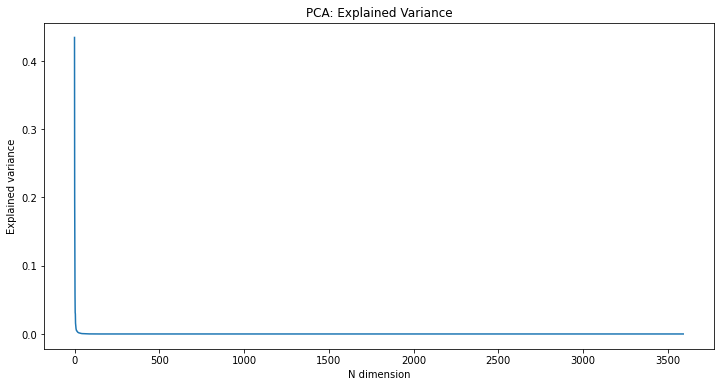

In [75]:
# "Elbow Method" plot to look at this
plt.figure(figsize=(12, 6))
plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, markersize=10)

plt.title('PCA: Explained Variance')
plt.xlabel('N dimension')
plt.ylabel('Explained variance')
plt.show()

In [76]:
# find "elbow"
kl = KneeLocator(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_,
                 curve="convex", direction="decreasing")

print('Elbow located at: {}'.format(kl.elbow))

Elbow located at: 24


In [77]:
# Let's keep 50 dimensions just to conservative
# how much variance do the first 50 dimensions explain?
n = 50
print('The first {} dimensions explain {:.2%} of the variance'.format(n, np.sum(pca.explained_variance_ratio_[:n])))

The first 50 dimensions explain 98.81% of the variance


In [78]:
# reduce X to the first 50 dimensions
X_reduced = np.matrix([row[:50] for row in X])
print(np.shape(X_reduced))

(3592, 50)


### K-Means Clustering
Now, we'll use the unsupervised method K means clustering to put each word (row) into a cluster of "similar" words. Each cluster can then be used as a node in a network.

This task has a lot of Researcher degrees of freedom because $k$ (the number of clusters) needs to be specified. The lower the value of $k$, the more words in each cluster -- which roughly means that clusters become more and more vague in what "concept(s)" they're reflecting.

In [79]:
# we'll use k-means clustering to identify which words are similar
# initialize our k-means algorithm

def get_kmeans(k, X):
    kmeans = KMeans(
        n_clusters=k
    )

    # run k-means!
    return kmeans.fit(X)

In [133]:
# Don't run this code, it takes for ever!

# K-Means is unsupervised, but it requires K to be specified
# iterate over potential values of k and measure how much error is produced from that value
'''
error = list() # save error for this value of k

for k in range(1,len(unique_words)): 
    if k%100 == 0:
        print('Checking k = {}'.format(k))
    kmeans = get_kmeans(k, X_reduced)
    error.append(kmeans.inertia_) # save sum of squared error (SSE)
    
print('{} values of k checked'.format(len(error)))
'''

Checking k = 100
Checking k = 200
Checking k = 300
Checking k = 400
Checking k = 500
Checking k = 600
Checking k = 700
Checking k = 800
Checking k = 900
Checking k = 1000
Checking k = 1100
Checking k = 1200
Checking k = 1300
Checking k = 1400
Checking k = 1500
Checking k = 1600
Checking k = 1700
1736 values of k checked


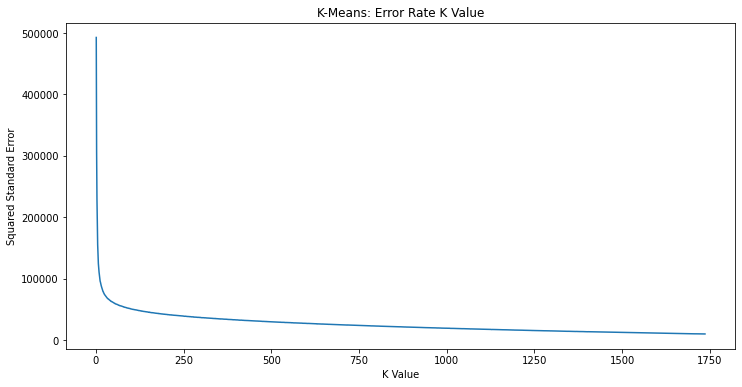

In [135]:
# Again, don't run this but you could use this code to determine a "good" number of clusters.

'''
kl = KneeLocator(range(1, len(error)+1), error, 
                 curve="convex", direction="decreasing")
print('Optimum number of clusters: {}'.format(kl.elbow))

# "Elbow Method" plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(error)+1), error, markersize=10)

# plt.xticks(np.arange(0, 21, 1))
plt.title('K-Means: Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Squared Standard Error')
plt.show()
'''

In [80]:
# Let's take k = 52 clusters
k = 52
kmeans = get_kmeans(k, X_reduced) # get our kmeans object

cluster_assignment = kmeans.labels_ # save the labels

print(cluster_assignment) # print the cluster assignments just to show
print(len(cluster_assignment)) # number of label (one for each token!)
print(len(trimmed)) # number of tokens

[28 32 13 ... 27 27 17]
3592
3592


In [81]:
# look at a random cluster
trimmed = np.array(trimmed)
trimmed[np.where(cluster_assignment==42)[0]]

array([criticisms, men, steps, promises, weeks, bodies, blows, others,
       years, jurists, years, eyes, fears, people, others, laws, laws,
       men, citizens, blocks, years, years, ills, men, workers, ways,
       ideologies, rides, ways, days, extremists, extremists, extremists,
       extremists, extremists, opponents, windows, worshipers, days,
       tears, nonconformists, days, millions, streets, times, wages,
       occasions, years, ends], dtype=object)

In [82]:
# Next, we'll name each cluster based on the most frequent word in it

# to do this, we start by creating a dictionary of words and occurance frequency
word_count = dict()

for token in trimmed:
    word_count.setdefault(token.lower_, 0)
    word_count[token.lower_] += 1
    
print(len(word_count))

1737


In [83]:
# now create two look up dictionaries

# cluster_lookup will have cluster labels (eg, 0) as keys 
# and most frequent word as the value
# we'll use this convert a cluster assignment into a text label
cluster_lookup = dict()

# size_lookup will store the text label for each cluster along with the
# total count of occurances of words in that cluster
# we'll use this to size nodes in our visualization
size_lookup = dict()

# iterate over cluster assignment values
for clust in set(cluster_assignment):
    tokens = trimmed[np.where(cluster_assignment==clust)[0]] # find the tokens for that cluster
    text = set([token.lower_ for token in tokens]) # get the text for each token
    
    # initialize things we want to track
    top_word = ''
    top_count = 0
    full_count = 0
    
    # iterate over the words in our cluster text
    for word in text:
        count = word_count[word] # retrieve frequency
        full_count += count # increment full count by this value
        
        if count > top_count: # if this count is more than we've seen previously
            top_word = word # this is now our top word
            top_count = count # this is now our top count
    
    cluster_lookup[clust] = top_word # save top word as value for this cluster
    size_lookup[top_word] = full_count # save full count as value for text label
    
# finally, we'll make one more lookup dictionary, 
# where we can lookup a textcluster assignment for a given token
token_lookup = dict((token, cluster_lookup[clust]) for token, clust in zip(trimmed, cluster_assignment))

## Build the network

Here we'll leverage SpaCy's [Dependency Parser](https://spacy.io/usage/linguistic-features) and say that word A is connected to word B if either word is the other's grammatical "head" (eg, what in the sentence is it modifying/refering to)

We'll treat each cluster as a "mega node" so if words A and B are both in the same cluster and A is connected to C and B is connected to D, our cluster-node will have edges to C and D.

In [84]:
G = nx.Graph() # empty graph

# iterate over tokens
for token in trimmed:
    
    # get cluster name
    n1 = token_lookup[token]
    
    # see if the grammatical head is a saved token
    try:
        n2 = token_lookup[token.head]
        
    except KeyError:
        n2 = 0 # if is not a saved token default to 0
        
    # add node 1 (our token) to the network
    G.add_node(n1)
    
    # if we found an edge, add it!
    if n2 != 0:
        G.add_edge(n1, n2)
        G[n1][n2].setdefault('weight', 0)
        G[n1][n2]['weight'] += 1
        
print('Network constructed')

Network constructed


In [85]:
# save just the largest connected component
G_c = max(nx.connected_components(G), key=len)

sub = G.subgraph(G_c).copy()

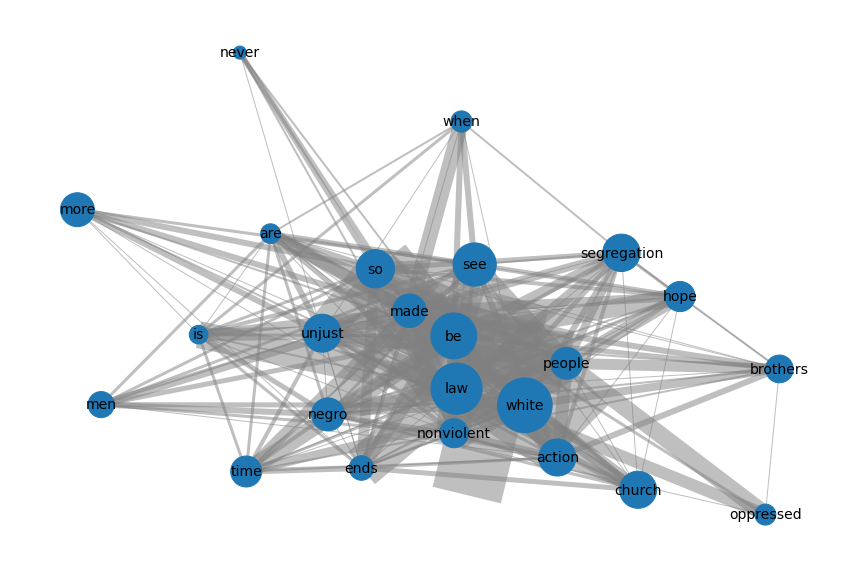

In [86]:
# visualize!

plt.figure(figsize=(12,8))
pos = nx.spring_layout(sub, seed=42) 
        
node_size = [size_lookup[node]*10 for node in sub.nodes()]
nx.draw_networkx_nodes(sub, pos, node_size=node_size)

# edges
edge_width = [details['weight'] for i, j, details in sub.edges(data=True)]
nx.draw_networkx_edges(sub, pos, width=edge_width, 
                       edge_color='grey', alpha=0.5)


# labels
nx.draw_networkx_labels(sub, pos, 
                        font_size=14)

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Final thoughts
There is a lot of researcher freedom in working with both text and networks -- there are **a lot** of choices about how you can define things. This means there's a lot of room for creativity but also a strong need to validate and to look carefully at your data. 

**Never take algorithmic output as object "Truth!"